# English-to-Spanish translation with a sequence-to-sequence Transformer

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2021/05/26<br>
**Last modified:** 2022/02/25<br>
**Description:** Implementing a sequence-to-sequene Transformer and training it on a machine translation task.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Introduction

In this example, we'll build a sequence-to-sequence Transformer model, which
we'll train on an English-to-Spanish machine translation task.

You'll learn how to:

- Vectorize text using the Keras `TextVectorization` layer.
- Implement a `TransformerEncoder` layer, a `TransformerDecoder` layer,
and a `PositionalEmbedding` layer.
- Prepare data for training a sequence-to-sequence model.
- Use the trained model to generate translations of never-seen-before
input sentences (sequence-to-sequence inference).

The code featured here is adapted from the book
[Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition)
(chapter 11: Deep learning for text).
The present example is fairly barebones, so for detailed explanations of
how each building block works, as well as the theory behind Transformers,
I recommend reading the book.

## Setup

In [1]:
import pathlib
import random
import string
import re
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization

## Downloading the data

We'll be working with an English-to-Spanish translation dataset
provided by [Anki](https://www.manythings.org/anki/). Let's download it:

In [ ]:
text_file = keras.utils.get_file(
    fname="English-Spanish.txt.zip",
    origin="/content/drive/MyDrive/English-Spanish.txt.zip",
    extract=True,
)
text_file = pathlib.Path(text_file).parent / "spa-eng" / "spa.txt"

ValueError: ignored

## Parsing the data

Each line contains an English sentence and its corresponding Spanish sentence.
The English sentence is the *source sequence* and Spanish one is the *target sequence*.
We prepend the token `"[start]"` and we append the token `"[end]"` to the Spanish sentence.

In [3]:
with open("/content/drive/MyDrive/English-Spanish.txt") as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
    eng, spa = line.split("\t")[0], line.split("\t")[1]
    spa = "[start] " + spa + " [end]"
    text_pairs.append((eng, spa))

Here's what our sentence pairs look like:

In [4]:
for _ in range(5):
    print(random.choice(text_pairs))

("What's the purpose of your visit?", '[start] ¿Cuál es el motivo de su visita? [end]')
('Tom sat next to Mary on the couch.', '[start] Tom se sentó junto a María en el sofá. [end]')
("The dog's sleeping in the car.", '[start] El perro está durmiendo en el carro. [end]')
("I didn't get the point of his speech.", '[start] No pillé cuál era la esencia de su discurso. [end]')
('I agree to your proposal.', '[start] Estoy de acuerdo con tu propuesta. [end]')


Now, let's split the sentence pairs into a training set, a validation set,
and a test set.

In [5]:
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples :]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

139705 total pairs
97795 training pairs
20955 validation pairs
20955 test pairs


## Vectorizing the text data

We'll use two instances of the `TextVectorization` layer to vectorize the text
data (one for English and one for Spanish),
that is to say, to turn the original strings into integer sequences
where each integer represents the index of a word in a vocabulary.

The English layer will use the default string standardization (strip punctuation characters)
and splitting scheme (split on whitespace), while
the Spanish layer will use a custom standardization, where we add the character
`"¿"` to the set of punctuation characters to be stripped.

Note: in a production-grade machine translation model, I would not recommend
stripping the punctuation characters in either language. Instead, I would recommend turning
each punctuation character into its own token,
which you could achieve by providing a custom `split` function to the `TextVectorization` layer.

In [6]:
strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

vocab_size = 15000
sequence_length = 20
batch_size = 64


def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


eng_vectorization = TextVectorization(
    max_tokens=vocab_size, output_mode="int", output_sequence_length=sequence_length,
)
spa_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)
train_eng_texts = [pair[0] for pair in train_pairs]
train_spa_texts = [pair[1] for pair in train_pairs]
eng_vectorization.adapt(train_eng_texts)
spa_vectorization.adapt(train_spa_texts)

Next, we'll format our datasets.

At each training step, the model will seek to predict target words N+1 (and beyond)
using the source sentence and the target words 0 to N.

As such, the training dataset will yield a tuple `(inputs, targets)`, where:

- `inputs` is a dictionary with the keys `encoder_inputs` and `decoder_inputs`.
`encoder_inputs` is the vectorized source sentence and `encoder_inputs` is the target sentence "so far",
that is to say, the words 0 to N used to predict word N+1 (and beyond) in the target sentence.
- `target` is the target sentence offset by one step:
it provides the next words in the target sentence -- what the model will try to predict.

In [7]:

def format_dataset(eng, spa):
    eng = eng_vectorization(eng)
    spa = spa_vectorization(spa)
    return ({"encoder_inputs": eng, "decoder_inputs": spa[:, :-1],}, spa[:, 1:])


def make_dataset(pairs):
    eng_texts, spa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(16).cache()


train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

Let's take a quick look at the sequence shapes
(we have batches of 64 pairs, and all sequences are 20 steps long):

In [8]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (64, 20)
inputs["decoder_inputs"].shape: (64, 20)
targets.shape: (64, 20)


## Building the model

Our sequence-to-sequence Transformer consists of a `TransformerEncoder`
and a `TransformerDecoder` chained together. To make the model aware of word order,
we also use a `PositionalEmbedding` layer.

The source sequence will be pass to the `TransformerEncoder`,
which will produce a new representation of it.
This new representation will then be passed
to the `TransformerDecoder`, together with the target sequence so far (target words 0 to N).
The `TransformerDecoder` will then seek to predict the next words in the target sequence (N+1 and beyond).

A key detail that makes this possible is causal masking
(see method `get_causal_attention_mask()` on the `TransformerDecoder`).
The `TransformerDecoder` sees the entire sequences at once, and thus we must make
sure that it only uses information from target tokens 0 to N when predicting token N+1
(otherwise, it could use information from the future, which would
result in a model that cannot be used at inference time).

In [9]:

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "dense_dim": self.dense_dim,
            "num_heads": self.num_heads,
        })
        return config


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)
    def get_config(self):
        config = super().get_config()
        config.update({
            "sequence_length": self.sequence_length,
            "vocab_size": self.vocab_size,
            "embed_dim": self.embed_dim,
        })
        return config


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1, attention_weights_1= self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask, return_attention_scores=True
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2, attention_weights_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask, return_attention_scores=True
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output), attention_weights_1, attention_weights_2


    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "latent_dim": self.latent_dim,
            "num_heads": self.num_heads,
        })
        return config


Next, we assemble the end-to-end model.

In [10]:
embed_dim = 256
latent_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x,aw1,aw2 = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
decoder_outputs = layers.Dropout(0.5)(x)
#decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], [decoder_outputs,aw1,aw2])

[decoder_outputs,aw11,aw22] = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)

In [11]:
from tensorflow.keras.utils import plot_model

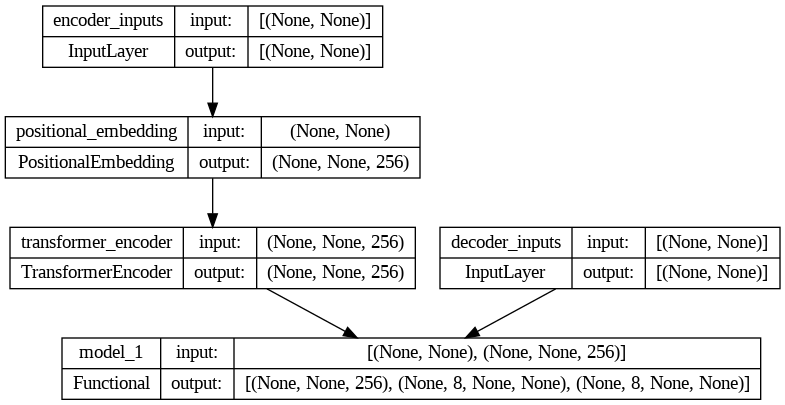

In [12]:
plot_model(transformer, show_shapes=True)

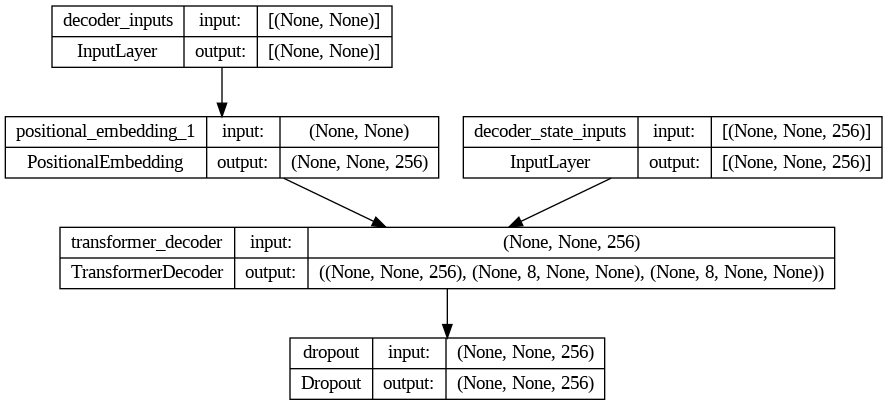

In [13]:
plot_model(decoder, show_shapes=True)

In [ ]:
for element in train_ds.take(1).as_numpy_iterator():
    print(element[0]['decoder_inputs'].shape)

(64, 20)


## Training our model

We'll use accuracy as a quick way to monitor training progress on the validation data.
Note that machine translation typically uses BLEU scores as well as other metrics, rather than accuracy.

Here we only train for 1 epoch, but to get the model to actually converge
you should train for at least 30 epochs.

In [15]:
epochs = 1  # This should be at least 30 for convergence

transformer.summary()
transformer.compile(
    "adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
transformer.fit(train_ds.take(100), epochs=epochs, validation_data=val_ds)

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional_embedding (Position  (None, None, 256)   3845120     ['encoder_inputs[0][0]']         
 alEmbedding)                                                                                     
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 transformer_encoder (Transform  (None, None, 256)   3155456     ['positional_embedding[

## Decoding test sentences

Finally, let's demonstrate how to translate brand new English sentences.
We simply feed into the model the vectorized English sentence
as well as the target token `"[start]"`, then we repeatedly generated the next token, until
we hit the token `"[end]"`.

In [ ]:
spa_vocab = spa_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 20


def decode_sequence(input_sentence):
    tokenized_input_sentence = eng_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = spa_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence


test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(30):
    # input_sentence = random.choice(test_eng_texts)
    input_sentence = "Deep Learning is widely used in Natural Language Processing, as Dr. Sun said in CSC 495/693."
    translated = decode_sequence(input_sentence)

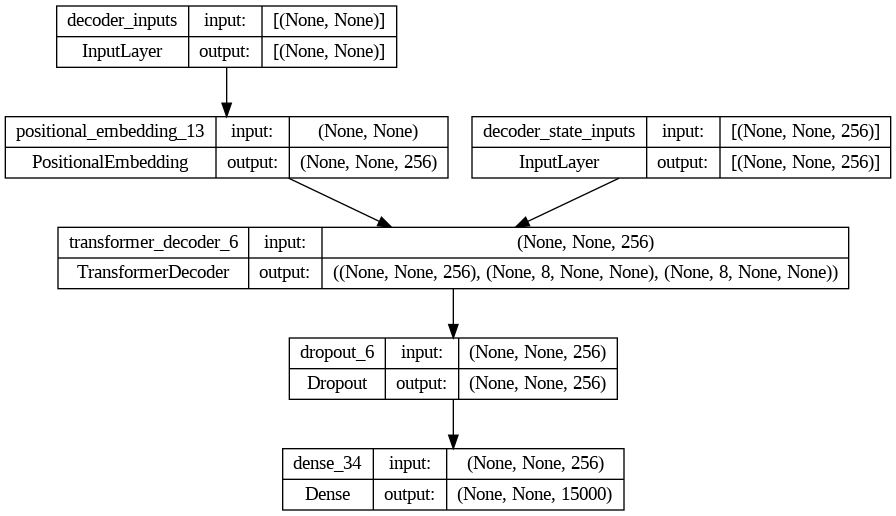

In [ ]:
plot_model(decoder,show_shapes=True)

In [ ]:
decoder.predict([spa_vectorization(['[start]'])[:, :-1], np.zeros((1, sequence_length, embed_dim))])

1/1 [==============================] - 0s 20ms/step


[array([[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32),
 array([[[[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]],
 
         [[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]],
 
         [[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]

In [ ]:
input_sequence = eng_vectorization([input_sentence])
encoded_sequence = encoder.predict(input_sequence)

# initialize decoder input with start token
decoder_input = spa_vectorization(['[start]'])[:, :-1]

# initialize decoder states with zeros
decoder_states = np.zeros((1, sequence_length, embed_dim))

# initialize list to store attention weights
attention_weights = []
print
# iterate until max length or end token is generated

for _ in range(1):
    decoder_output, aw1, aw2 = decoder.predict([decoder_input, decoder_states])
    attention_weights.append((aw1, aw2))
    decoder_states = np.concatenate([decoder_states, decoder_output], axis=1)
    decoder_token = np.argmax(decoder_output[0, -1, :])
    decoder_input = np.array([[decoder_token]])
    if decoder_token == spa_tokenizer.word_index['[end]'] or decoder_states.shape[1] == max_length:
        break

predicted_sentence = ' '.join([target_tokenizer.index_word[token] for token in decoder_states[0].argmax(axis=-1)])


1/1 [==============================] - 0s 31ms/step


NameError: ignored

In [ ]:
translated

'[start] [UNK] que es el dolor de que [UNK] [UNK] que el sol dijo que [UNK] en el sol [end]'

After 30 epochs, we get results such as:

> She handed him the money.
> [start] ella le pasó el dinero [end]

> Tom has never heard Mary sing.
> [start] tom nunca ha oído cantar a mary [end]

> Perhaps she will come tomorrow.
> [start] tal vez ella vendrá mañana [end]

> I love to write.
> [start] me encanta escribir [end]

> His French is improving little by little.
> [start] su francés va a [UNK] sólo un poco [end]

> My hotel told me to call you.
> [start] mi hotel me dijo que te [UNK] [end]